## Estimating a uni/multi-variate hidden markov switching model 


In [15]:
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt 
import statsmodels.api as sm

In [16]:
### pdf function of normal distribution 
def norm_pdf(x,    ## value of the rm 
             μ,    ## mean of the normal
             σ):   ## std of the normal 
    """
    pdf of normal distribution mean μ and variance σ^2
    """
    x_new = (x-μ)/σ
    temp1 = 1/(np.sqrt(2*np.pi))
    temp2 = np.exp(-(x_new**2/2))
    return temp1*temp2 

def prob_func(x):
    """
    this bound function maps unconstrained x to y between 0, and 1
    , and it increases with x
    """
    return np.exp(x)/(1+np.exp(x))     

def prob_func_inv(y):
    return np.log(y)-np.log(1-y)

## exp_func  from R --> [0,+infinity]
def exp_func(x):
    return np.exp(x)

def exp_func_inv(y):
    return np.log(y)

def steady_state(q,
                 p):
    """
    a function that computes the ss of a 2-state markov 
    """
    return ((1-p)/(2-p-q),
            (1-q)/(2-p-q))

In [17]:
class Markov2Switching:
    """
    A class that stores primitives for the Markov Regime Switching Model
    %%%% Model %%%%%%%
    % y_t = alpha+ beta * s_t + epsilon_t
    % y is the observed variable;
    % s_t =1 in high state; s_t = 0 in low state;
    % q=p(s_t=0|s_t-1=0)
    % p=p(s_t=1|s_t-1=1)
    % Transition Matrix from [s=0,s=1]' is [q,1-p;1-q,p] 
    % para_est stores all estimates of parameters. 
    %%%%%%%%%%%%%%%%%

    """

    def __init__(self,
                 Y = None,
                 paras = np.array([0.1,0.1,0.1,0.7,0.7]),
                 nb_var = 1,
                 state_dependence = False,
                 AR = 0):  
        
        ## count how many variables 
        self.nb_var = nb_var
        
        if AR==0:
            assert self.nb_var == int(len(paras)/5),'the nb of paras needs to be equal to 5 x nb of variables'
        elif AR==1:
            assert self.nb_var == int(len(paras)/6),'the nb of paras needs to be equal to 6 x nb of variables'
          
        self.paras = paras.reshape(self.nb_var,-1)
        
        self.Y = Y
        ## be careful with the order 
        self.αs = self.paras[:,0]
        self.βs = self.paras[:,1]
        self.σs = self.paras[:,2]
        self.qs = self.paras[:,3]
        self.ps = self.paras[:,4]
        if AR==0:
            self.ϕ1s =np.zeros(self.nb_var)
        elif AR==1:
            self.ϕ1s = self.paras[:,5]
        self.state_dependence = state_dependence
        self.AR = AR 
    
    ## The functions below are help functions 
    ## that turn a hard constraint on parameters values to an unconstrained problem
    ## prob_func  from R -> [0,1]

    def get_model_para(self,
                      para):
        """
        unconstrained parameters recast into model parameters with constraints
        """
        assert len(para)==self.nb_var*(5+self.AR),"the nb of parameters is incorrect"
        paras = para.reshape(self.nb_var,-1)
        
        αs = paras[:,0]
        βs = paras[:,1]
        #np.concatenate([self.exp_func(paras[0:2,1]),
        #                     np.array(-self.exp_func([paras[2,1]]))
        #                    ])
        σs = exp_func(paras[:,2])
        qs = prob_func(paras[:,3])
        ps = prob_func(paras[:,4])
        if self.AR==1:
            ϕ1s = prob_func(paras[:,5])
        else:
            ϕ1s = np.zeros(self.nb_var)
        return αs,βs,σs,qs,ps,ϕ1s
    
    def make_para_dict(self,
                      para):
        """
        a function that creates a dictionary of parameters with names
        """
        αs,βs,σs,qs,ps,ϕ1s = self.get_model_para(para)
            
        q = qs[0]
        p =ps[0]
        
        model_para ={}
        model_para['q']=q
        model_para['p']=p
        model_para['α']=αs
        model_para['β']=βs
        model_para['σ'] =σs
        model_para['ϕ1']=ϕ1s
                   
        return model_para
    
    ## The key function that computes log-likelihood for a list of time series of realized data
    def log_likelihood(self,
                       Y_list,   ## a list of multiple series 
                       para):
        
        """
        inputs
        ======
        Y: a list of independent univariate/multivariate (a vector) time series for which the log-likelihood is computed jointly
        para: parameters of the process sized of nb of variables x nb of parameters, with the strict order of α,β,σ,q,p,ϕ1
        
        outputs
        =======
        llh_tot: total log-likelihood across all series
        update1_list: list of updating probs s=1|Y_t at time t;
        prdict1_list: list of prediction probs: s=1|Y_t-1 at time t-1;
        f1_list: list of predicted probs: y_t|y_t-1;
        """
        αs,βs,σs,qs,ps,ϕ1s = self.get_model_para(para)

        update1_list =[]
        prdict1_list =[]
        f1_list =[]
        
        
        ## starting from zero loglikelihood 
        
        llh_tot = 0.0

        q = qs[0]
        p = ps[0]
        
        for k in range(len(Y_list)):
            Y = Y_list[k]  ## Y is a 1-d or nb_var-d array 
            
            T = Y_list[k].shape[1] ## length of the series is not necessarily the same 
            
            ## this loops over all periods 
            llh = 0.0

            update0 = np.empty(T)
            update1 = np.empty(T)
            prdict1 = np.empty(T)
            f1 = np.empty(T)

            ## initialize the first period
            update0[0], update1[0] = steady_state(q,   #p(s=0|Y_0) and  # p(s=1|Y_1)
                                                  p)   
            
            for t in range(1,T-1):
                prdict1[t] = (1-q)*update0[t-1]+p*update1[t-1]  #p(s_t=1|y_t-1);
                
                pdf_t_1 = prdict1[t]
                pdf_t_0 = (1-prdict1[t])
                
                ## loop over different time series
                for x in range(self.nb_var):
                    pdf_t_1 =pdf_t_1*norm_pdf(Y[x,t]-ϕ1s[x]*Y[x,t-1],αs[x]+βs[x],σs[x])  # f(y_t|s_t=1,Y_t-1)
                    pdf_t_0 =pdf_t_0*norm_pdf(Y[x,t]-ϕ1s[x]*Y[x,t-1],αs[x],σs[x]) # f(y_t|s_t=0,Y_t-1)
                
                f1[t]= pdf_t_1+pdf_t_0     # f1= f(y_t|Y_t-1)
                #print(f1[t])
                llh_pred = np.log(f1[t])     # log( f(y_t|Y_t-1))
                llh = llh + llh_pred         # llh_pred = log(f(y_t|Y_t-1))
                update1[t] = pdf_t_1/(pdf_t_1+ pdf_t_0)  # p(s_t=0|y_t-1) 
                update0[t] = 1-update1[t]                # p(s_t=1|y_t-1)
                
            ## merge those probabilities 
            
            update1_list.append(update1) 
            prdict1_list.append(prdict1)
            f1_list.append(f1)
        
            ## sum across agents 
            llh_tot = llh_tot+llh
        
        return llh_tot,update1_list,prdict1_list,f1_list

In [18]:
if __name__ == "__main__":
    ## create the model 
    mkv2 = Markov2Switching(AR=0,
                            nb_var=1)

### Test using fake simulated data with known parameters

In [19]:
if __name__ == "__main__":

    import quantecon as qe
    from quantecon import MarkovChain

    ## fake parameters 
    α_fake = 0.1
    β_fake = 0.2
    σ_fake = 0.1
    q_fake = 0.7
    p_fake = 0.6
    ϕ1_fake = 0.0

    mkv_mat = np.array([[q_fake,1-q_fake],
                        [1-p_fake,p_fake]])

    para_fake = np.array([α_fake,
                          β_fake,
                          exp_func_inv(σ_fake),
                          prob_func_inv(q_fake),
                          prob_func_inv(p_fake),
                          #prob_func_inv(ϕ1_fake)
                         ])
    T_fake = 12
    nb_sim = 300

    fake_regime_h_list=[]
    fake_data_list = []

    prob_ss0, prob_ss1 = steady_state(q_fake,
                                      p_fake)

    init_sim = (np.random.uniform(0,1,nb_sim)<=prob_ss1)*1

    for i in range(nb_sim):
        mc = qe.MarkovChain(mkv_mat)
        regime_h = mc.simulate(ts_length=T_fake+1,
                              init= init_sim[i])
        regime_l = 1-regime_h
        shocks = np.random.randn(T_fake+1)*σ_fake
        constant_l = α_fake
        constant_h = α_fake+β_fake
        y = (regime_l*constant_l+regime_h*constant_h)+shocks
        ## AR1 process
        for t in range(1,T_fake):
            y[t]= ϕ1_fake*y[t-1]+y[t]

        ## add to the list 
        this_y_2d = y[1:].reshape(-1,len(y[1:]))
        fake_data_list.append(this_y_2d)
        fake_regime_h_list.append(regime_h)
    index = range(T_fake)

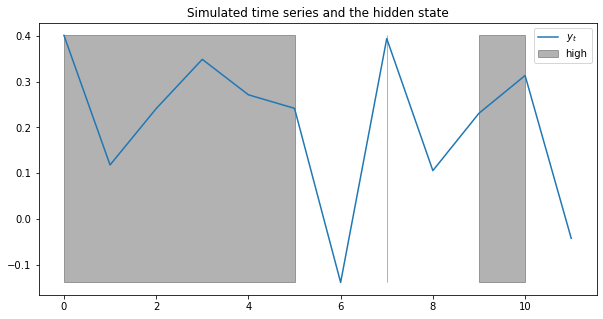

In [20]:
if __name__ == "__main__":

    ## plot the simulated data 
    if len(fake_data_list)==1:
        random_id = 0
    else:
        random_id = np.random.randint(0,len(fake_data_list)-1)

    ## get the random data and regime sequence
    y = fake_data_list[random_id].T
    regime_h = fake_regime_h_list[random_id]

    plt.figure(figsize=(10,5))
    plt.title('Simulated time series and the hidden state')
    plt.plot(y,
             label=r'$y_t$')
    plt.fill_between(index,
                     np.min(y),
                     np.max(y),
                     where=regime_h[1:],
                     color="k", 
                     alpha=0.3,
                    label='high')
    plt.legend(loc=1)

In [21]:
if __name__ == "__main__":

    ## plot log-likelihood based on the true parameters 

    llh,filter1,pr1,pdf = mkv2.log_likelihood(fake_data_list,
                                              para_fake)

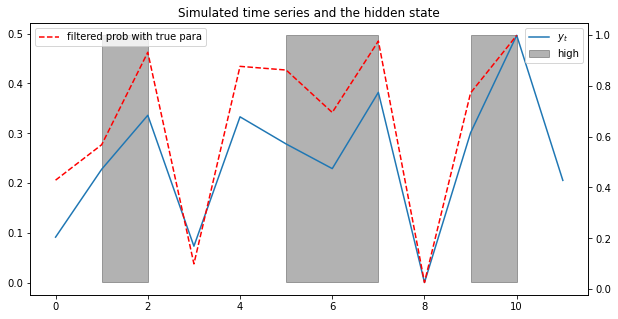

In [22]:
if __name__ == "__main__":

    ## plot the simulated data 
    if len(fake_data_list)==1:
        random_id = 0
    else:
        random_id = np.random.randint(0,len(fake_data_list)-1)

    ## get the random data and regime sequence
    y = fake_data_list[random_id].T
    regime_h = fake_regime_h_list[random_id]

    ## plot everything 
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title('Simulated time series and the hidden state')

    ## time series of y 
    ax.plot(y,label=r'$y_t$')
    ## regime 
    ax.fill_between(index,
                     np.min(y),
                     np.max(y),
                     where=regime_h[1:],
                     color="k", 
                     alpha=0.3,
                    label='high')
    
    ax2 = ax.twinx()
    ## filter prob
    ax2.plot(filter1[random_id][:-1],
             'r--',
            label='filtered prob with true para')
    ax.legend(loc=1)
    ax2.legend(loc=2)

In [ ]:
if __name__ == "__main__":

    ## try estimation

    obj = lambda para: -mkv2.log_likelihood(fake_data_list,
                                            para)[0]   ## only the first output


    ## tight bounds for some parameters 
    sigma_ub = np.mean([np.std(np.array(x)) for x in fake_data_list])
    sigma_inv_ub = exp_func_inv(sigma_ub)
    q_lb = 0.5  ## persistent 
    q_inv_lb = prob_func_inv(q_lb) 
    p_lb = 0.5 ## persistent 
    p_inv_lb = prob_func_inv(p_lb)

    ## estimation 
    #guess = (0.2,0.3,0.1,0.1,0.4)
    guess = para_fake
    #bounds = ((-0.3,1),(-2,2),(-2,2),(-4,1),(-4,1),) 
    bounds = ((None,None),(0.0,None),(-3,sigma_inv_ub),(None,None),(None,None),)

    result = minimize(obj,
                    x0 = guess,
                    method='trust-constr',   #trust-constr
                    bounds = bounds,
                    options={'disp': False,
                            }
                       )
    print('success? ',result['success'])
    para_est = result['x']


    para_fake_dict = mkv2.make_para_dict(para_fake)
    para_guess_dict = mkv2.make_para_dict(guess)
    para_est_dict = mkv2.make_para_dict(para_est)


    #results
    print("fake TRUE parameters\n",para_fake_dict)
    print("initial guess of the parameters\n",para_guess_dict)
    print("estimated parameters\n",para_est_dict)

In [ ]:
if __name__ == "__main__":

    #Based on estimates of parameters and data; compute filtered probabilities

    llh,filter1,pr1,pdf = mkv2.log_likelihood(fake_data_list,
                                              para_est)
    # filter1: prob of good state;
    # pr1: predicted prob of good state 

In [ ]:
if __name__ == "__main__":

    ## plot the simulated data 
    if len(fake_data_list)==1:
        random_id = 0
    else:
        random_id = np.random.randint(0,len(fake_data_list)-1)

    ## get the random data and regime sequence
    y = fake_data_list[random_id].T
    regime_h = fake_regime_h_list[random_id]


    ## plot everything 

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title('Simulated time series and the hidden state')

    ## time series of y 
    ax.plot(y,
             label=r'$y_t$')
    ## regime 
    ax.fill_between(index,
                     np.min(y),
                     np.max(y),
                     where=regime_h[1:],
                     color="k", 
                     alpha=0.3,
                    label='high')
    ax2 = ax.twinx()
    ## filter prob
    ax2.plot(filter1[random_id][:-1],
             'r--',
            label='filtered prob with est para')
    ax.legend(loc=1)
    ax2.legend(loc=2)